<a href="https://colab.research.google.com/github/mkhaleghian/SevenStates/blob/main/ML_SevenState.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import geopy.distance
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import folium
import re
import seaborn as sns
import math

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
      drive.mount('/content/drive')
      df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/7_states/Session-Details-Summary-20240119-3.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import geopy.distance
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import folium
import re
import seaborn as sns
from datetime import datetime
import pytz
from pytz import timezone


In [8]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [10]:
unique_values_time_zone = df['Start Time Zone'].unique()
print(unique_values_time_zone)

['EST' 'CST' 'PST' 'CDT' 'EDT' 'PDT']


In [11]:
# Convert Start and End Date to datetime
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

def convert_to_est(row, date_col, tz_col):
    tz_map = {'EST': 'America/New_York', 'CST': 'America/Chicago', 'CDT': 'America/Chicago', 'EDT': 'America/New_York', 'PDT': 'America/Los_Angeles', 'PST': 'America/Los_Angeles'}
    return row[date_col].tz_localize(tz=tz_map[row[tz_col]], ambiguous='NaT').tz_convert(tz='EST')


# Apply function to Start and End Date
df['Start_Time_EST'] = df.apply(convert_to_est, args=('Start Date', 'Start Time Zone'), axis=1)
df['End_Time_EST'] = df.apply(convert_to_est, args=('End Date', 'End Time Zone'), axis=1)

In [12]:
missing_count = df['Port Type'].value_counts().get('Missing', 0)
print(f"Number of missing values in 'Port Type': {missing_count}")

Number of missing values in 'Port Type': 0


In [13]:
df=df.dropna(subset=["Port Type"])

In [14]:
# Define the columns you want to keep
columns = ['Station Name', 'MAC Address', 'Org Name', 'Address 1', 'City', 'State/Province',
           'Zip/Postal Code', 'Driver Zip/Postal Code', 'User ID', 'Latitude', 'Longitude', 'Port Type',
           'Start_Time_EST', 'End_Time_EST', 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)',
           'Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Fee', 'Start SOC', 'End SOC',
           'System S/N', 'Model Number', 'Vehicle MAC ID']

# Create a new DataFrame for ML
df_ml = df[columns]

In [17]:
# Filter the data for the specific station
df_station = df_ml[df_ml['Station Name'] == "7SPC / SEVIERVILLE DC1"]

# Convert 'Start_Time_EST' to datetime if it's not already
df_station['Start_Time_EST'] = pd.to_datetime(df_station['Start_Time_EST'])

# Set 'Start_Time_EST' as the index
df_station.set_index('Start_Time_EST', inplace=True)

# Resample the data to daily energy consumption
daily_energy = df_station['Energy (kWh)'].resample('D').sum()

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(daily_energy.values.reshape(-1, 1))

# Split into train and test sets
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Reshape into X=t and Y=t+1
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Calculate root mean squared error
train_score = math.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))


<ipython-input-17-a86da560645f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station['Start_Time_EST'] = pd.to_datetime(df_station['Start_Time_EST'])


Epoch 1/100
618/618 - 2s - loss: 0.0276 - 2s/epoch - 3ms/step
Epoch 2/100
618/618 - 1s - loss: 0.0243 - 690ms/epoch - 1ms/step
Epoch 3/100
618/618 - 1s - loss: 0.0237 - 700ms/epoch - 1ms/step
Epoch 4/100
618/618 - 1s - loss: 0.0235 - 753ms/epoch - 1ms/step
Epoch 5/100
618/618 - 1s - loss: 0.0234 - 898ms/epoch - 1ms/step
Epoch 6/100
618/618 - 1s - loss: 0.0233 - 694ms/epoch - 1ms/step
Epoch 7/100
618/618 - 1s - loss: 0.0233 - 695ms/epoch - 1ms/step
Epoch 8/100
618/618 - 1s - loss: 0.0233 - 690ms/epoch - 1ms/step
Epoch 9/100
618/618 - 1s - loss: 0.0234 - 794ms/epoch - 1ms/step
Epoch 10/100
618/618 - 1s - loss: 0.0233 - 908ms/epoch - 1ms/step
Epoch 11/100
618/618 - 1s - loss: 0.0233 - 936ms/epoch - 2ms/step
Epoch 12/100
618/618 - 1s - loss: 0.0233 - 686ms/epoch - 1ms/step
Epoch 13/100
618/618 - 1s - loss: 0.0233 - 691ms/epoch - 1ms/step
Epoch 14/100
618/618 - 1s - loss: 0.0234 - 692ms/epoch - 1ms/step
Epoch 15/100
618/618 - 1s - loss: 0.0233 - 678ms/epoch - 1ms/step
Epoch 16/100
618/618 -

In [18]:
df_L2 = df[(df['Port Type'].str.fullmatch('Level 2'))]

df_DC = df[(df['Port Type'].str.fullmatch('DC Fast'))]

Level 2: 21490
DC Fast: 15453


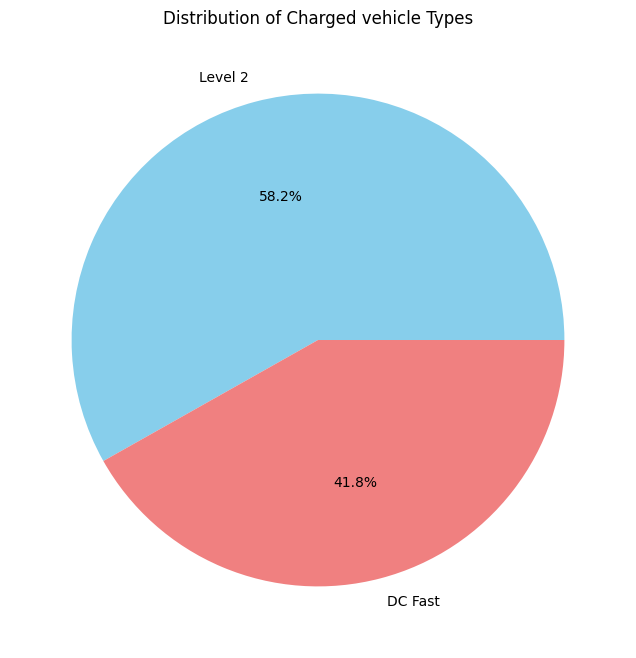

In [19]:
# Count the number of Level 2 and DC Fast charging stations
count_by_port_type = df['Port Type'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(8, 8))
count_by_port_type.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Charged vehicle Types')
plt.ylabel('')  # Remove the default ylabel

# Print the count of Level 2 and DC Fast charging stations
for port_type, count in count_by_port_type.items():
    print(f"{port_type}: {count}")

plt.show()


In [ ]:
df_L2.columns

Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'Address 2', 'City', 'State/Province',
       'Zip/Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency',
       'Fee', 'Ended By', 'Plug In Event ID', 'Transaction ID',
       'Driver Zip/Postal Code', 'User ID', 'Start SOC', 'End SOC', 'County',
       'System S/N', 'Model Number', 'OnRamp ID Tag',
       'Payment Terminal Session ID', 'Vehicle MAC ID'],
      dtype='object')

In [ ]:
def convert_duration_to_seconds(duration):
    if isinstance(duration, str):
        parts = duration.split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds = int(parts[2].split()[0])  # Extract seconds and ignore 'AM' or 'PM'
        total_seconds = hours * 3600 + minutes * 60 + seconds
        return total_seconds
    elif isinstance(duration, datetime.time):
        return duration.hour * 3600 + duration.minute * 60 + duration.second
    else:
        return 0  # Handle other cases if needed

# Assuming 'Total Duration' is in string format '1:26:32 AM'
df_L2['Total Duration (hh:mm:ss)'] = df_L2['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds)
df_DC['Total Duration (hh:mm:ss)'] = df_DC['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds)

<ipython-input-21-2f8e8e3464af>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_L2['Total Duration (hh:mm:ss)'] = df_L2['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds)
<ipython-input-21-2f8e8e3464af>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DC['Total Duration (hh:mm:ss)'] = df_DC['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds)


In [ ]:
df_DC['Total Duration (hh:mm:ss)']

0        4042
3        2180
4        1625
5        1867
6        6252
         ... 
17339    4222
17340    3013
17342     567
17343     885
17344     643
Name: Total Duration (hh:mm:ss), Length: 9124, dtype: int64

In [ ]:
# For DC fast charging sites
df_DC['Total Duration (hh:mm:ss)'] = pd.to_numeric(df_DC['Total Duration (hh:mm:ss)'], errors='coerce')
df_DC['Energy (kWh)'] = pd.to_numeric(df_DC['Energy (kWh)'], errors='coerce')
df_DC['Fee'] = pd.to_numeric(df_DC['Fee'], errors='coerce')

DC_usage = df_DC.groupby('Station Name').agg({
    'Total Duration (hh:mm:ss)': ['count', 'mean'],
    'Energy (kWh)': ['sum', 'mean'],
    'Fee': ['sum', 'mean']
}).reset_index()

<ipython-input-23-693cfb724c0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DC['Total Duration (hh:mm:ss)'] = pd.to_numeric(df_DC['Total Duration (hh:mm:ss)'], errors='coerce')
<ipython-input-23-693cfb724c0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DC['Energy (kWh)'] = pd.to_numeric(df_DC['Energy (kWh)'], errors='coerce')
<ipython-input-23-693cfb724c0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [ ]:
DC_usage

Station Name Total Duration (hh:mm:ss)               \
                                                        count         mean   
0             7SPC / GREENEVILLE TA                       423  1830.059102   
1            7SPC / SEVIERVILLE DC1                      1049  2316.593899   
2              7SPC / TTU DC FAST 1                       362  2304.906077   
3              AEC / STATION #1 (L)                       108  1708.333333   
4              AEC / STATION #2 (R)                        84  1906.202381   
5              BEA / STATION 1 (LL)                        60  2733.850000   
6              BEA / STATION 2 (LM)                        55  1845.818182   
7              BEA / STATION 3 (RM)                        73  1863.397260   
8              BEA / STATION 4 (RR)                        61  2025.918033   
9                BRMEMC / STATION 1                       209  1841.540670   
10               BRMEMC / STATION 2                       277  1636.729242   
11            BTES / STATION 1 (LL)                        82  2223.365854   
12            BTES / STATION 2 (LM)                        67  2107.164179   
13            BTES / STATION 3 (RM)                       125  2191.336000   
14            BTES / STATION 4 (RR)                       106  2221.028302   
15     CULLMANELECTRIC / STATION1-L                       837  1400.292712   
16     CULLMANELECTRIC / STATION2-R                       600  1432.285000   
17      DISTRICT 2 / STATION #1 (L)                         4  3272.500000   
18       DISTRICT 2 / STATION 1 (L)                        54  1758.685185   
19       DISTRICT 2 / STATION 2 (R)                        47  1770.425532   
20              FPIA / LEFT STATION                       652  1619.142638   
21             FPIA / RIGHT STATION                       721  1785.456311   
22      I24 EXIT11 / STATION 1 (LL)                        92  1583.771739   
23      I24 EXIT11 / STATION 2 (LM)                       124  1719.846774   
24      I24 EXIT11 / STATION 3 (RM)                       207  1643.961353   
25      I24 EXIT11 / STATION 4 (RR)                       323  1928.699690   
26  JEFFERSON AVE. / OXFORD STA1(L)                       107  2313.971963   
27  JEFFERSON AVE. / OXFORD STA2(R)                       111  2548.927928   
28         LAWRENCEBURG / STATION 1                         1  3213.000000   
29     LAWRENCEBURG / STATION 1 (L)                       112  1594.562500   
30     LAWRENCEBURG / STATION 2 (R)                       142  1621.359155   
31         PARIS BPU / STATION 1(L)                        39  2639.487179   
32         PARIS BPU / STATION 2(R)                        36  1988.416667   
33                 PEPA / STATION 1                       210  2343.509524   
34                 PEPA / STATION 2                       140  2112.542857   
35   SCOTTSBORO EPB / SEPB DCFC (L)                        42  2237.000000   
36   SCOTTSBORO EPB / SEPB DCFC (R)                        47  2160.340426   
37            STEMC / STATION 1 (L)                        36  1897.638889   
38            STEMC / STATION 2 (R)                        31  1976.032258   
39              WCMES / CITYHALL1-L                       175  2059.234286   
40              WCMES / CITYHALL2-R                       221  2280.950226   
41                WRECC / STATION 1                       255  1935.352941   
42                WRECC / STATION 2                       617  1902.270665   

   Energy (kWh)                 Fee             
            sum       mean      sum       mean  
0      8717.592  20.608965  3430.88   8.110827  
1     25398.308  24.211924  8660.62   8.256072  
2      8719.875  24.088052  2226.27   6.149917  
3      2403.161  22.251491  1009.30   9.345370  
4      2175.291  25.896321   913.66  10.876905  
5      1878.626  31.310433   789.08  13.151333  
6      1589.351  28.897291   667.54  12.137091  
7      1663.520  22.787945   698.69   9.571096  
8      1858.868  30.47

In [ ]:
# For L2 fast charging sites
df_L2['Total Duration (hh:mm:ss)'] = pd.to_numeric(df_L2['Total Duration (hh:mm:ss)'], errors='coerce')
df_L2['Energy (kWh)'] = pd.to_numeric(df_L2['Energy (kWh)'], errors='coerce')
df_L2['Fee'] = pd.to_numeric(df_L2['Fee'], errors='coerce')

L2_usage = df_L2.groupby('Station Name').agg({
    'Total Duration (hh:mm:ss)': ['count', 'mean'],
    'Energy (kWh)': ['sum', 'mean'],
    'Fee': ['sum', 'mean']
}).reset_index()


<ipython-input-25-5805cb8564e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_L2['Total Duration (hh:mm:ss)'] = pd.to_numeric(df_L2['Total Duration (hh:mm:ss)'], errors='coerce')
<ipython-input-25-5805cb8564e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_L2['Energy (kWh)'] = pd.to_numeric(df_L2['Energy (kWh)'], errors='coerce')
<ipython-input-25-5805cb8564e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [ ]:
L2_usage

Station Name Total Duration (hh:mm:ss)  \
                                                          count   
0                 7SPC / CFEC SPENCER                        22   
1               7SPC / DOLLYWOOD EMPL                        51   
2                 7SPC / NASA USSRC L                       469   
3                 7SPC / NASA USSRC R                       526   
4               7SPC / SCES DOLLYWOOD                       379   
5              7SPC / SCES DREAM MORE                       434   
6               7SPC / SCES LECONTE 1                        43   
7               7SPC / SCES LECONTE 2                        28   
8               7SPC / SCES LECONTE 3                        41   
9               7SPC / SCES LECONTE 4                       112   
10                  7SPC / SMITHVILLE                        65   
11                   7SPC / SPARTA TN                        54   
12              7SPC / TRI-COUNTY EMC                        28   
13                7SPC / TVPPA OFFICE                       207   
14               7SPC / UC - CARTHAGE                       166   
15             7SPC / UC - LIVINGSTON                       102   
16               7SPC / VEC BYRDSTOWN                        22   
17               7SPC / VEC JAMESTOWN                        28   
18              7SPC / WARREN RECC BG                       184   
19              7SPC / WARREN RECC LF                        36   
20                  AEC / CORP OFFICE                       130   
21     BRIGHTRIDGE EV / BR-JC LIBRARY                       309   
22   BRIGHTRIDGE EV / BR-JONESBOROUGH                       223   
23                 BTES / BTES OFFICE                        23   
24                   BTES / CITY HALL                       102   
25                      CLW / MAIN ST                       406   
26             CRMC / CRMC-1 - L2LEFT                        68   
27             CRMC / CRMC-2- L2RIGHT                        31   
28             CULLMAN PB / STATION 1                       169   
29  CULLMANELECTRIC / CEC MAIN OFFICE                       115   
30                EASY AUTO / OFFICE1                       160   
31                  EASY AUTO / SHOP1                        19   
32            EBOFG / GUNTERSVILLE PD                       542   
33          HARTSELLE 1 / HARTSELLE 1                       219   
34        HOLSTONELECTRIC / STATION 1                        38   
35   LODGE CAST IRON / STORE & MUSEUM                       210   
36               MU / MUC MAIN OFFICE                        28   
37               MU / MUC PWRENG BLDG                        21   
38           NEMEPA / NEMEPA CUSTOMER                        85   
39           NEMEPA / NEMEPA EMPLOYEE                        19   
40                 PES / LEFT STATION                       102   
41                PES / RIGHT STATION                         9   
42       SCOTTSBORO EPB / MAIN OFFICE                       151   
43  STARKVILLE UTIL / STARKVILLE DWTN                       374   
44   STARKVILLE UTIL / STARKVILLE REC                       137   
45          UT PARKING / S7 STATION 1                       444   

                  Energy (kWh)                 Fee             
             mean          sum       mean      sum       mean  
0     3230.136364      125.490   5.704091    20.45   0.929545  
1     7437.490196      506.005   9.921667   106.28   2.083922  
2     8628.441365     5501.667  11.730633  1158.58   2.470320  
3     8887.933460     6638.512  12.620745  1359.78   2.585133  
4    16064.894459     8392.357  22.143422  1905.27   5.027098  
5    14764.557604     7673.922  17.681848  2017.35   4.648272  
6    10280.116279      748.454  17.405907   127.57   2.966744  
7    10025.035714      446.361  15.941464    78.29   2.796071  
8     9851.585366      563.392  13.741268   124.61   3.039268  
9    10525.982143     1813.529  16.192223   346.15   3.090625  
10   21122.846154      870.949  13.39921

# Total vehicles Chrging Type

In [ ]:
value_counts_station_name= df["Station Name"].value_counts()
unique_values_column_station_name = df['Station Name'].unique()


print(value_counts_station_name)
#print(unique_values_column_station_name)

7SPC / SEVIERVILLE DC1          1049
CULLMANELECTRIC / STATION1-L     837
FPIA / RIGHT STATION             721
FPIA / LEFT STATION              652
WRECC / STATION 2                617
                                ... 
NEMEPA / NEMEPA EMPLOYEE          19
EASY AUTO / SHOP1                 19
PES / RIGHT STATION                9
DISTRICT 2 / STATION #1 (L)        4
LAWRENCEBURG / STATION 1           1
Name: Station Name, Length: 89, dtype: int64


In [ ]:
value_counts_User_name= df["User ID"].value_counts()
print(value_counts_User_name)

35312191    281
23114351    149
39956041    146
36794241    112
32776001    102
           ... 
26440881      1
41985881      1
22322151      1
41974371      1
25881291      1
Name: User ID, Length: 4400, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '35312191'),
  Text(1, 0, '23114351'),
  Text(2, 0, '39956041'),
  Text(3, 0, '36794241'),
  Text(4, 0, '32776001'),
  Text(5, 0, '31948601'),
  Text(6, 0, '26789031'),
  Text(7, 0, '345831V'),
  Text(8, 0, '21698361'),
  Text(9, 0, '34108791'),
  Text(10, 0, '2577471'),
  Text(11, 0, '31321161'),
  Text(12, 0, '27405401'),
  Text(13, 0, '28493451'),
  Text(14, 0, '35914251'),
  Text(15, 0, '19948981'),
  Text(16, 0, '28519711'),
  Text(17, 0, '33864851'),
  Text(18, 0, '33732041'),
  Text(19, 0, '36564161'),
  Text(20, 0, '24517611'),
  Text(21, 0, '30255411'),
  Text(22, 0, '35649101'),
  Text(23, 0, '36839191'),
  Text(24, 0, '30969821'),
  Text(25, 0, '22460041'),
  Text(26, 0, '25211751'),
  Text(27, 0, '35255021'),
  Text(28, 0, '41653461'),
  Text(29, 0, '33545831')])

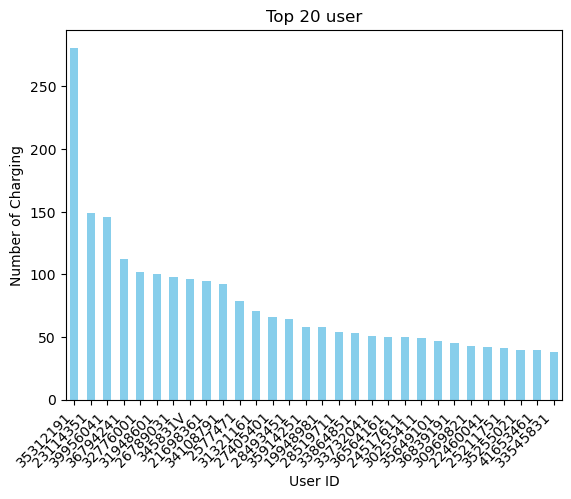

In [ ]:
top_30_users = value_counts_User_name.sort_values(ascending=False).head(30)

figsize=(10, 6)
top_30_users.plot(kind='bar', color='skyblue')
plt.title('Top 20 user')
plt.xlabel('User ID')
plt.ylabel('Number of Charging')
plt.xticks(rotation=45, ha='right')

In [ ]:
unique_vehicles_per_station = df.groupby('Station Name')['User ID'].nunique()
print (unique_vehicles_per_station)

Station Name
7SPC / CFEC SPENCER           13
7SPC / DOLLYWOOD EMPL         16
7SPC / GREENEVILLE TA        165
7SPC / NASA USSRC L          252
7SPC / NASA USSRC R          239
                            ... 
UT PARKING / S7 STATION 1     96
WCMES / CITYHALL1-L           44
WCMES / CITYHALL2-R           50
WRECC / STATION 1            109
WRECC / STATION 2            192
Name: User ID, Length: 89, dtype: int64


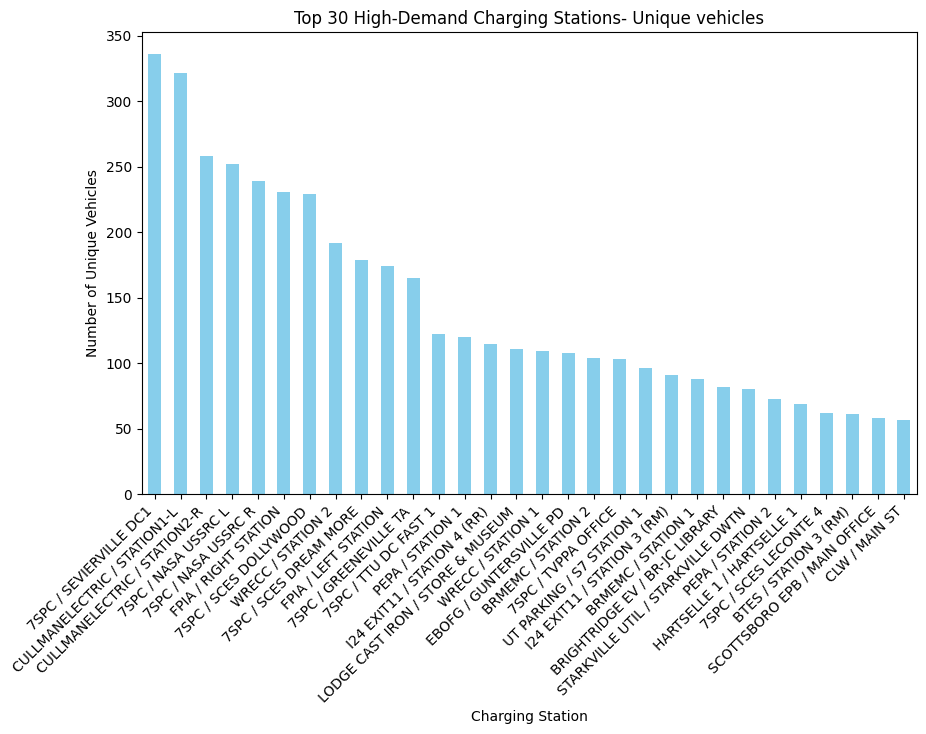

In [ ]:
# Assuming 'unique_vehicles_per_station' is the Series you obtained
top_30_stations = unique_vehicles_per_station.sort_values(ascending=False).head(30)

# Plotting
plt.figure(figsize=(10, 6))
top_30_stations.plot(kind='bar', color='skyblue')
plt.title('Top 30 High-Demand Charging Stations- Unique vehicles')
plt.xlabel('Charging Station')
plt.ylabel('Number of Unique Vehicles')
plt.xticks(rotation=45, ha='right')
plt.show()


# Unique vehicle DC

In [ ]:
value_counts_station_name_DC= df_DC["Station Name"].value_counts()
unique_values_column_station_name_DC = df_DC['Station Name'].unique()


print(value_counts_station_name_DC)

7SPC / SEVIERVILLE DC1             1049
CULLMANELECTRIC / STATION1-L        837
FPIA / RIGHT STATION                721
FPIA / LEFT STATION                 652
WRECC / STATION 2                   617
CULLMANELECTRIC / STATION2-R        600
7SPC / GREENEVILLE TA               423
7SPC / TTU DC FAST 1                362
I24 EXIT11 / STATION 4 (RR)         323
BRMEMC / STATION 2                  277
WRECC / STATION 1                   255
WCMES / CITYHALL2-R                 221
PEPA / STATION 1                    210
BRMEMC / STATION 1                  209
I24 EXIT11 / STATION 3 (RM)         207
WCMES / CITYHALL1-L                 175
LAWRENCEBURG / STATION 2 (R)        142
PEPA / STATION 2                    140
BTES / STATION 3 (RM)               125
I24 EXIT11 / STATION 2 (LM)         124
LAWRENCEBURG / STATION 1 (L)        112
JEFFERSON AVE. / OXFORD STA2(R)     111
AEC / STATION #1 (L)                108
JEFFERSON AVE. / OXFORD STA1(L)     107
BTES / STATION 4 (RR)               106


In [ ]:
value_counts_User_name_DC= df_DC["User ID"].value_counts()
print(value_counts_User_name_DC)

35312191    280
23114351    149
28519711     54
33864851     53
36564161     50
           ... 
41048771      1
24211171      1
44087531      1
25168341      1
30478991      1
Name: User ID, Length: 2587, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '35312191'),
  Text(1, 0, '23114351'),
  Text(2, 0, '28519711'),
  Text(3, 0, '33864851'),
  Text(4, 0, '36564161'),
  Text(5, 0, '24517611'),
  Text(6, 0, '25211751'),
  Text(7, 0, '35255021'),
  Text(8, 0, '22460041'),
  Text(9, 0, '33545831'),
  Text(10, 0, '35926581'),
  Text(11, 0, '37376481'),
  Text(12, 0, '631985'),
  Text(13, 0, '42356801'),
  Text(14, 0, '598917'),
  Text(15, 0, '32571961'),
  Text(16, 0, '32394181'),
  Text(17, 0, '29015001'),
  Text(18, 0, '33010671'),
  Text(19, 0, '38915831'),
  Text(20, 0, '30385091'),
  Text(21, 0, '35129521'),
  Text(22, 0, '34516611'),
  Text(23, 0, '345661V'),
  Text(24, 0, '38462821'),
  Text(25, 0, '40187391'),
  Text(26, 0, '36262221'),
  Text(27, 0, '37008351'),
  Text(28, 0, '38194641'),
  Text(29, 0, '35621651')])

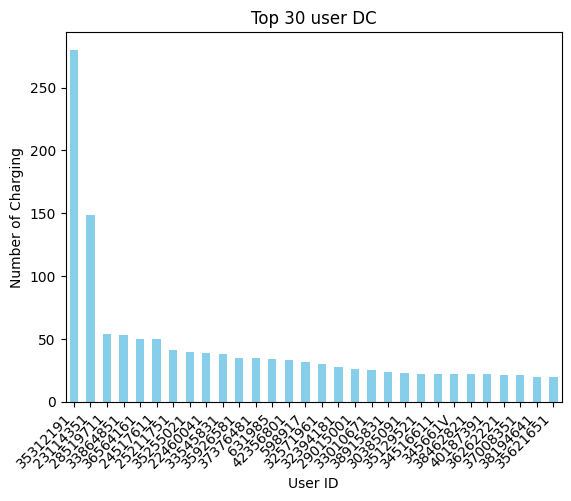

In [ ]:
top_30_users_DC = value_counts_User_name_DC.sort_values(ascending=False).head(30)

figsize=(10, 6)
top_30_users_DC.plot(kind='bar', color='skyblue')
plt.title('Top 30 user DC')
plt.xlabel('User ID')
plt.ylabel('Number of Charging')
plt.xticks(rotation=45, ha='right')

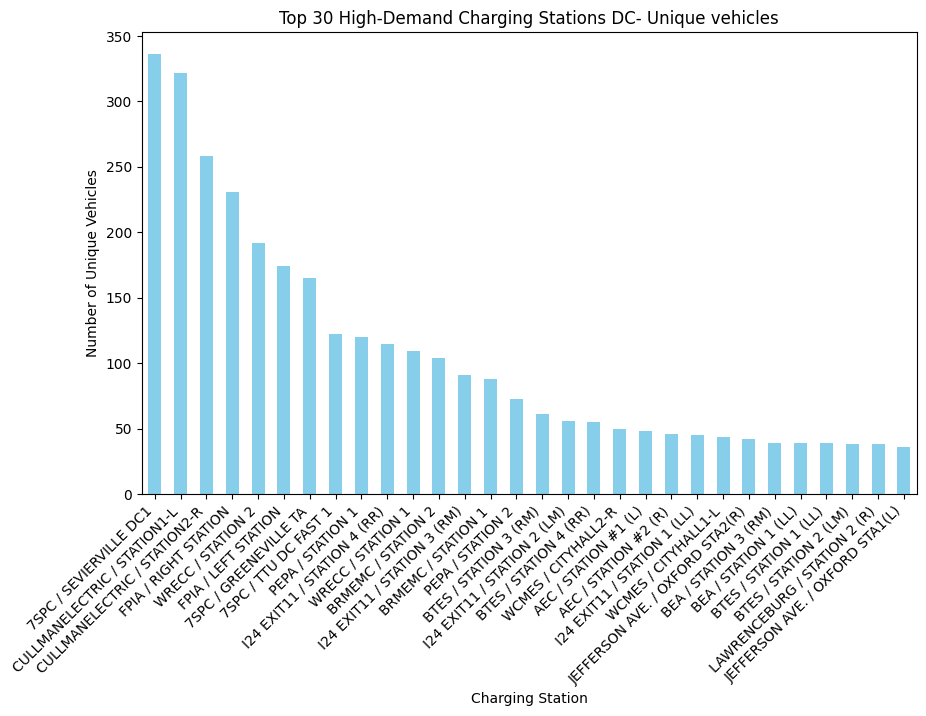

In [ ]:
unique_vehicles_per_station_DC = df_DC.groupby('Station Name')['User ID'].nunique()
#print (unique_vehicles_per_station)

top_30_stations_DC = unique_vehicles_per_station_DC.sort_values(ascending=False).head(30)

# Plotting
plt.figure(figsize=(10, 6))
top_30_stations_DC.plot(kind='bar', color='skyblue')
plt.title('Top 30 High-Demand Charging Stations DC- Unique vehicles')
plt.xlabel('Charging Station')
plt.ylabel('Number of Unique Vehicles')
plt.xticks(rotation=45, ha='right')
plt.show()

# L2

In [ ]:
value_counts_station_name_L2= df_L2["Station Name"].value_counts()
unique_values_column_station_name_L2 = df_L2['Station Name'].unique()
value_counts_User_name_L2= df_L2["User ID"].value_counts()


#print(value_counts_station_name_L2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '39956041'),
  Text(1, 0, '36794241'),
  Text(2, 0, '31948601'),
  Text(3, 0, '32776001'),
  Text(4, 0, '26789031'),
  Text(5, 0, '345831V'),
  Text(6, 0, '21698361'),
  Text(7, 0, '34108791'),
  Text(8, 0, '2577471'),
  Text(9, 0, '31321161'),
  Text(10, 0, '27405401'),
  Text(11, 0, '28493451'),
  Text(12, 0, '19948981'),
  Text(13, 0, '35914251'),
  Text(14, 0, '33732041'),
  Text(15, 0, '30255411'),
  Text(16, 0, '36839191'),
  Text(17, 0, '35649101'),
  Text(18, 0, '41653461'),
  Text(19, 0, '30965751'),
  Text(20, 0, '25930191'),
  Text(21, 0, '23712821'),
  Text(22, 0, '36464281'),
  Text(23, 0, '30969821'),
  Text(24, 0, '611995'),
  Text(25, 0, '26479151'),
  Text(26, 0, '24639591'),
  Text(27, 0, '35873791'),
  Text(28, 0, '42073701'),
  Text(29, 0, '22457141')])

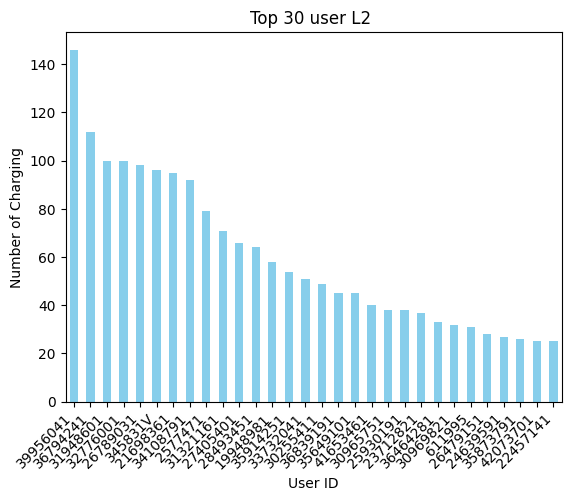

In [ ]:
top_30_users_L2 = value_counts_User_name_L2.sort_values(ascending=False).head(30)

figsize=(10, 6)
top_30_users_L2.plot(kind='bar', color='skyblue')
plt.title('Top 30 user L2 ')
plt.xlabel('User ID')
plt.ylabel('Number of Charging')
plt.xticks(rotation=45, ha='right')

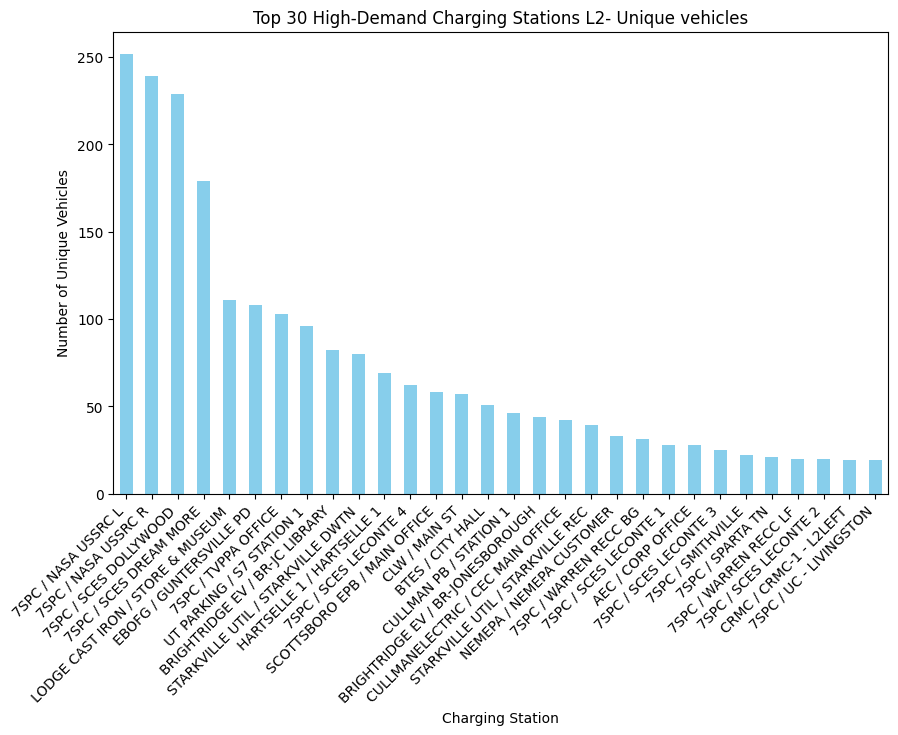

In [ ]:
unique_vehicles_per_station_L2 = df_L2.groupby('Station Name')['User ID'].nunique()
#print (unique_vehicles_per_station)

top_30_stations_L2 = unique_vehicles_per_station_L2.sort_values(ascending=False).head(30)

# Plotting
plt.figure(figsize=(10, 6))
top_30_stations_L2.plot(kind='bar', color='skyblue')
plt.title('Top 30 High-Demand Charging Stations L2- Unique vehicles')
plt.xlabel('Charging Station')
plt.ylabel('Number of Unique Vehicles')
plt.xticks(rotation=45, ha='right')
plt.show()

# Perform a utilization analysis over time

Utilization analysis: Look at usage rates over time for each station - how often is it occupied, peak usage times, etc. This can help guide pricing, load balancing, and future expansion plans​.

In [ ]:
df['Transaction Date (Pacific Time)'] = pd.to_datetime(df['Transaction Date (Pacific Time)'])
df['Hour'] = df['Transaction Date (Pacific Time)'].dt.hour
utilization_data = df.groupby(['Station Name', 'Hour']).size().reset_index(name='Transaction Count')


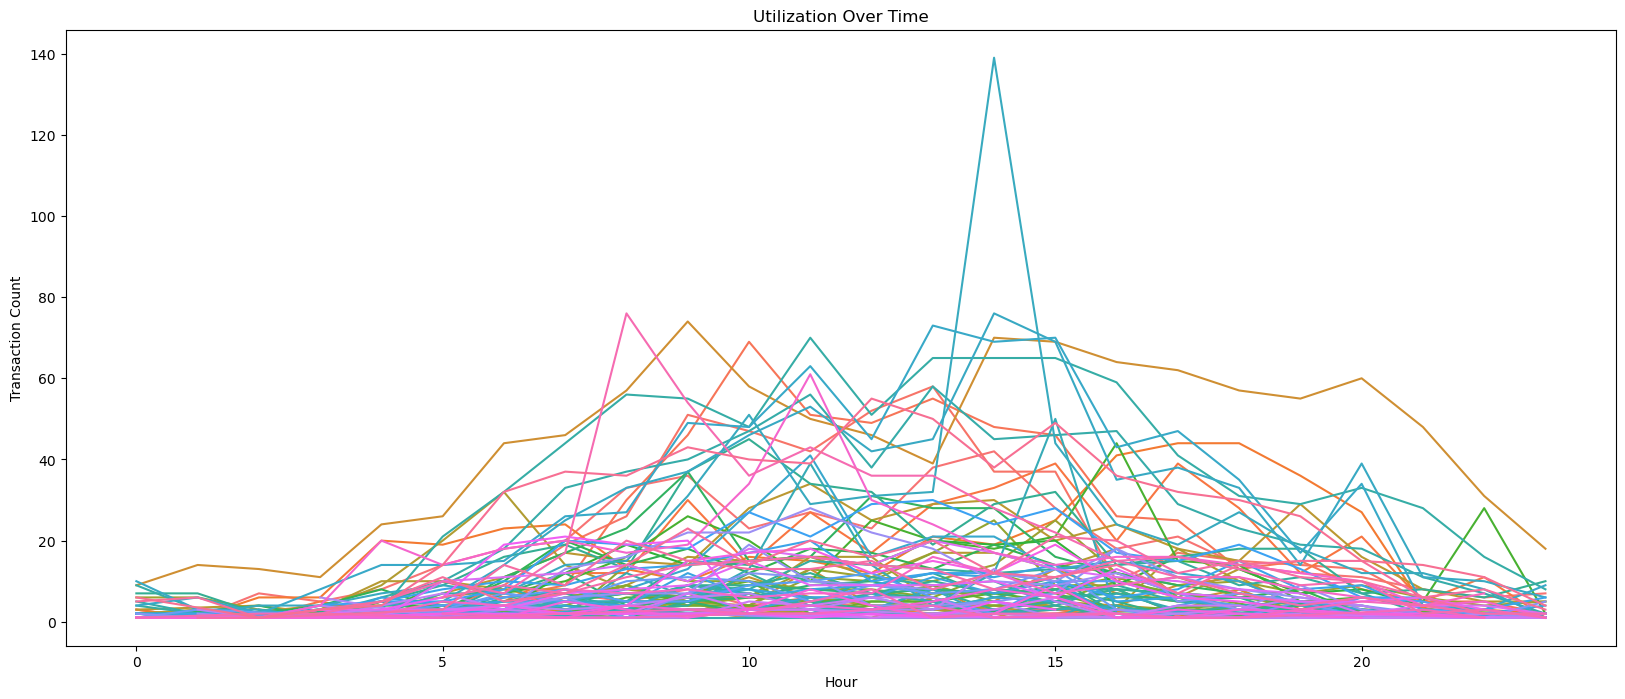

In [ ]:
plt.figure(figsize=(20, 8))
sns.lineplot(x='Hour', y='Transaction Count', hue='Station Name', data=utilization_data,legend=False)
plt.title('Utilization Over Time')
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
#plt.legend(title='Station Name')
plt.show()

In [ ]:
# Assuming 'Transaction Date' is in datetime format
df['Month'] = df['Transaction Date (Pacific Time)'].dt.month

# Grouping by Station Name and Month
utilization_by_month = df.groupby(['Station Name', 'Month']).size().reset_index(name='Transaction Count')


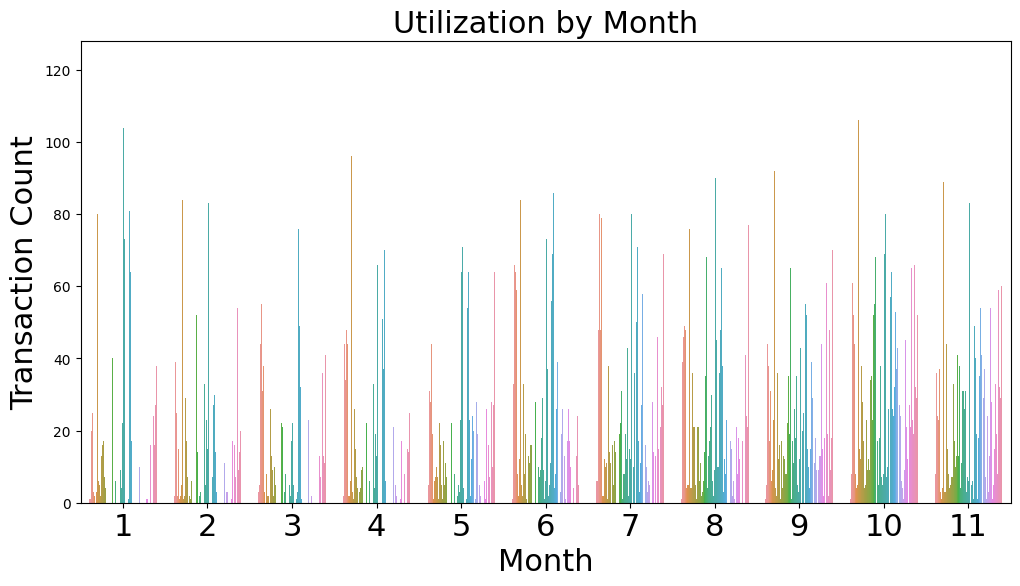

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Month', y='Transaction Count', hue='Station Name', data=utilization_by_month)
plt.title('Utilization by Month', fontsize=22)

ax.set_xlabel('Month', fontsize=22)
ax.set_ylabel('Transaction Count', fontsize=22)
ax.tick_params(axis='x', labelsize=22)
plt.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticks() + 1)

plt.show()


### L2

In [ ]:
df_L2['Transaction Date (Pacific Time)'] = pd.to_datetime(df_L2['Transaction Date (Pacific Time)'])
df_L2['Hour'] = df_L2['Transaction Date (Pacific Time)'].dt.hour
utilization_data_L2 = df_L2.groupby(['Station Name', 'Hour']).size().reset_index(name='Transaction Count')


<ipython-input-44-0e86639dc557>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_L2['Transaction Date (Pacific Time)'] = pd.to_datetime(df_L2['Transaction Date (Pacific Time)'])
<ipython-input-44-0e86639dc557>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_L2['Hour'] = df_L2['Transaction Date (Pacific Time)'].dt.hour


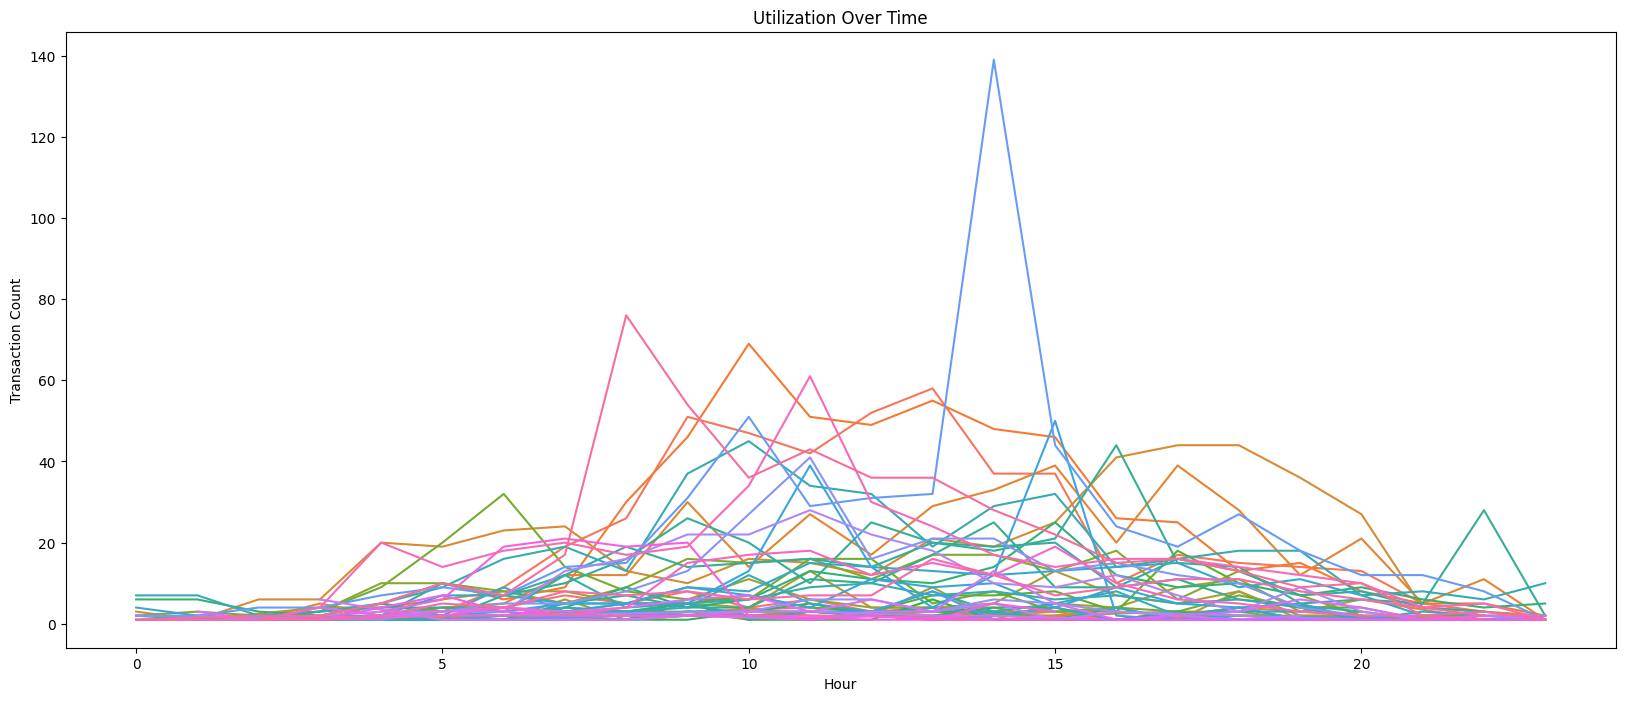

In [ ]:
plt.figure(figsize=(20, 8))
sns.lineplot(x='Hour', y='Transaction Count', hue='Station Name', data=utilization_data_L2,legend=False)
plt.title('Utilization Over Time')
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
#plt.legend(title='Station Name')
plt.show()

### DC fast

In [ ]:
df_DC['Transaction Date (Pacific Time)'] = pd.to_datetime(df_DC['Transaction Date (Pacific Time)'])
df_DC['Hour'] = df_DC['Transaction Date (Pacific Time)'].dt.hour
utilization_data_DC = df_DC.groupby(['Station Name', 'Hour']).size().reset_index(name='Transaction Count')

<ipython-input-46-f4196d24d747>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DC['Transaction Date (Pacific Time)'] = pd.to_datetime(df_DC['Transaction Date (Pacific Time)'])
<ipython-input-46-f4196d24d747>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DC['Hour'] = df_DC['Transaction Date (Pacific Time)'].dt.hour


In [ ]:
utilization_data_DC

,Station Name,Hour,Transaction Count
0,7SPC / GREENEVILLE TA,0.0,3
1,7SPC / GREENEVILLE TA,1.0,1
2,7SPC / GREENEVILLE TA,2.0,7
3,7SPC / GREENEVILLE TA,3.0,5
4,7SPC / GREENEVILLE TA,4.0,8
...,...,...,...
807,WRECC / STATION 2,19.0,26
808,WRECC / STATION 2,20.0,15
809,WRECC / STATION 2,21.0,14
810,WRECC / STATION 2,22.0,11


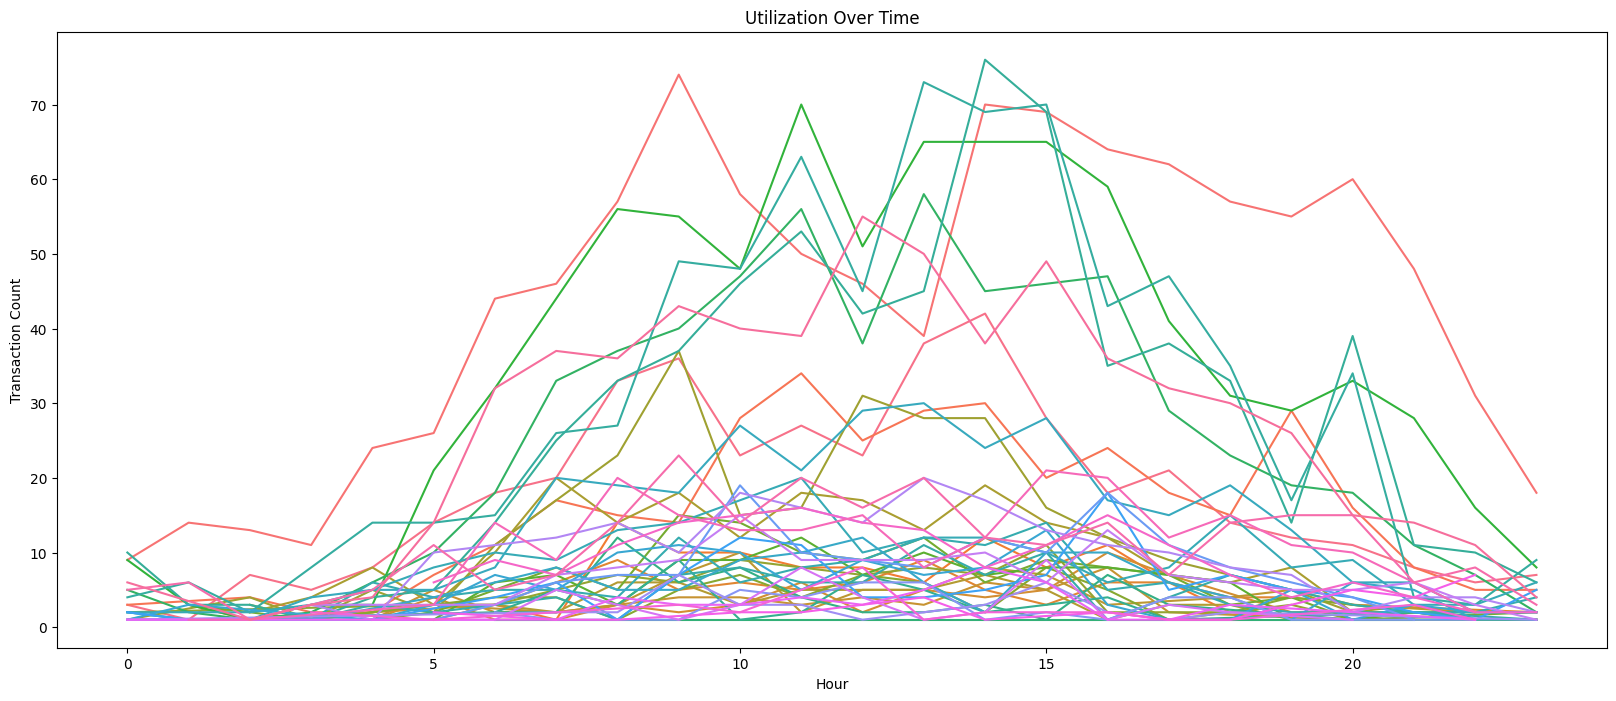

In [ ]:
plt.figure(figsize=(20, 8))
sns.lineplot(x='Hour', y='Transaction Count', hue='Station Name', data=utilization_data_DC, legend=False)
plt.title('Utilization Over Time')
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
#plt.legend(title='Station Name')
plt.show()